In [1]:
import numpy as np
import torch
import mirdata
import soundfile as sf
import tensorly as tl

import musicae.model.features as features
import musicae.data_manipulation as dm
import musicae.autosimilarity_segmentation as as_seg
import musicae.neural_nets_utils as nn_utils
import musicae.convolutional as conv_ae
from musicae.model.current_plot import *

In [2]:
path_to_beatles_dataset = 'C:/Users/amarmore/this_folder/Beatles dataset/'
beatles = mirdata.initialize('beatles', path_to_beatles_dataset)
beatles.download()

# NB: you have to place the file "01_-_Come_Together.wav" manually in the folder "audio/11_-_Abbey_Road/"
come_together = beatles.track('1101')

references_segments = beatles.load_sections(come_together.sections_path).intervals

INFO: Downloading ['annotations'] to C:/Users/amarmore/this_folder/Beatles dataset/
INFO: [annotations] downloading The Beatles Annotations.tar.gz
INFO: C:/Users/amarmore/this_folder/Beatles dataset/annotations\The Beatles Annotations.tar.gz already exists and will not be downloaded. Rerun with force_overwrite=True to delete this file and force the download.
INFO: 
    Unfortunately the audio files of the Beatles dataset are not available
    for download. If you have the Beatles dataset, place the contents into
    a folder called Beatles with the following structure:
        > Beatles/
            > annotations/
            > audio/
    and copy the Beatles folder to C:/Users/amarmore/this_folder/Beatles dataset/



In [3]:
the_signal, sampling_rate = sf.read(come_together.audio_path)
bars = dm.get_bars_from_audio(come_together.audio_path)

C:\Users\amarmore\AppData\Local\Continuum\anaconda3\envs\test_icassp_nn\lib\site-packages\madmom\io\audio.py:493: WavFileWarning: Chunk (non-data) not understood, skipping it.
  file_sample_rate, signal = wavfile.read(filename, mmap=True)


In [4]:
hop_length = 32
hop_length_seconds = hop_length/44100
subdivision_bars = 96

## Chromagram

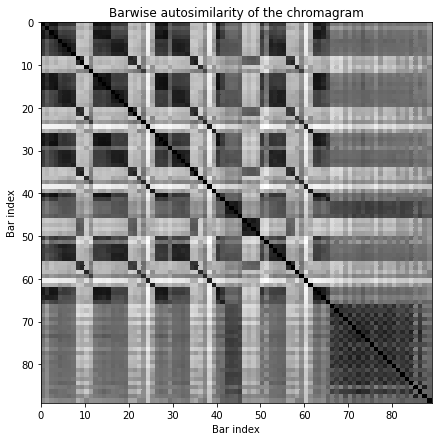

In [5]:
chromagram = features.get_spectrogram(the_signal, sampling_rate, "pcp", hop_length = hop_length)
pcp_x_axis = chromagram.shape[0]

chroma_tensor_barwise = nn_utils.tensorize_barwise(chromagram, bars, hop_length_seconds, subdivision_bars)
chromagram_autosimilarity = as_seg.get_autosimilarity(tl.unfold(chroma_tensor_barwise,0), transpose = True, normalize = True)

plot_me_this_spectrogram(chromagram_autosimilarity, title = "Barwise autosimilarity of the chromagram", x_axis = "Bar index", y_axis = "Bar index")
nb_bars = chroma_tensor_barwise.shape[0]

In [6]:
chroma_data_loader = nn_utils.generate_dataloader(chroma_tensor_barwise)
conv_chroma_model = conv_ae.ConvolutionalAutoencoder(input_size_x = subdivision_bars, input_size_y = pcp_x_axis, dim_latent_space = 16)
print(conv_chroma_model)
conv_chroma_model = conv_chroma_model.my_optim_method(1000, chroma_data_loader, lr=1e-3, verbose = False)

ConvolutionalAutoencoder(
  (conv1): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(4, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc): Linear(in_features=1152, out_features=16, bias=True)
  (i_fc): Linear(in_features=16, out_features=1152, bias=True)
  (t_conv1): ConvTranspose2d(16, 4, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  (t_conv2): ConvTranspose2d(4, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
)


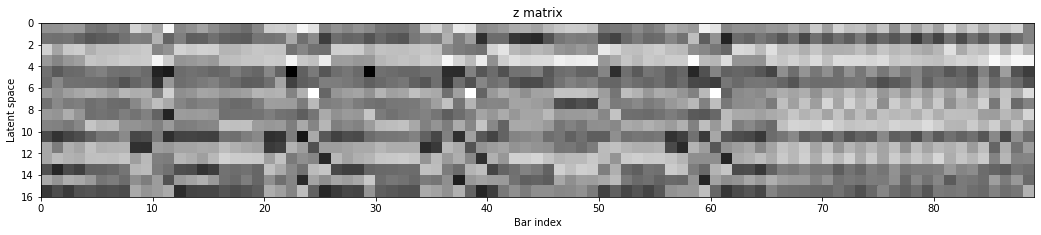

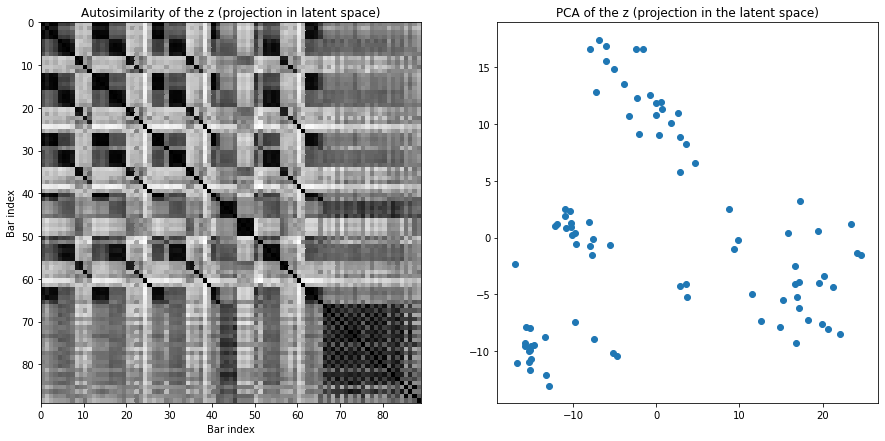

In [7]:
projection_chroma = conv_chroma_model.get_latent_projection(chroma_data_loader)
plot_latent_space(projection_chroma)

In [ ]:
autosimilarity_chroma_projection = as_seg.get_autosimilarity(projection_chroma, transpose = True, normalize = True)
segments_chroma_ae = as_seg.dynamic_convolution_computation(autosimilarity_chroma_projection, penalty_weight = 1, penalty_func = "modulo8", convolution_type = "mixed")[0]
segments_chroma_ae_in_time = dm.segments_from_bar_to_time(segments_chroma_ae, bars)

score_chroma_ae_zero_five = dm.compute_score_of_segmentation(references_segments, segments_chroma_ae_in_time, window_length = 0.5)
print(f"Score with 0.5 second tolerance: Precision {score_chroma_ae_zero_five[0]}, Recall {score_chroma_ae_zero_five[1]}, F measure {score_chroma_ae_zero_five[2]}")
score_chroma_ae_three = dm.compute_score_of_segmentation(references_segments, segments_chroma_ae_in_time, window_length = 3)
print(f"Score with 0.5 second tolerance: Precision {score_chroma_ae_three[0]}, Recall {score_chroma_ae_three[1]}, F measure {score_chroma_ae_three[2]}")

## MFCC

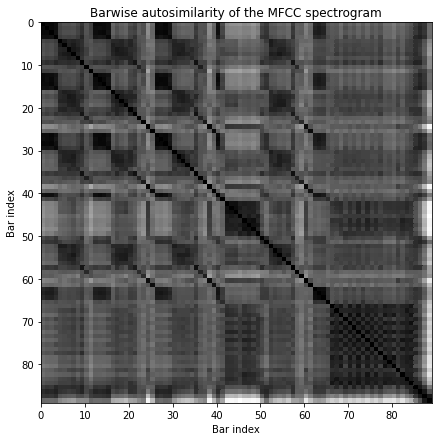

In [8]:
mfcc_gram = features.get_spectrogram(the_signal, sampling_rate, "mfcc", hop_length = hop_length, n_mfcc = 32)
mfcc_x_axis = mfcc_gram.shape[0]

mfcc_tensor_barwise = nn_utils.tensorize_barwise(mfcc_gram, bars, hop_length_seconds, subdivision_bars)
mfcc_autosimilarity = as_seg.get_autosimilarity(tl.unfold(mfcc_tensor_barwise,0), transpose = True, normalize = True)
plot_me_this_spectrogram(mfcc_autosimilarity, title = "Barwise autosimilarity of the MFCC spectrogram", x_axis = "Bar index", y_axis = "Bar index")

In [9]:
mfcc_data_loader = nn_utils.generate_dataloader(mfcc_tensor_barwise)

conv_mfcc_model = conv_ae.ConvolutionalAutoencoder(input_size_x = subdivision_bars, input_size_y = mfcc_x_axis, dim_latent_space = 16)
print(conv_mfcc_model)
conv_mfcc_model = conv_mfcc_model.my_optim_method(1000, mfcc_data_loader, lr=1e-3,verbose = False)

ConvolutionalAutoencoder(
  (conv1): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(4, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc): Linear(in_features=3072, out_features=16, bias=True)
  (i_fc): Linear(in_features=16, out_features=3072, bias=True)
  (t_conv1): ConvTranspose2d(16, 4, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  (t_conv2): ConvTranspose2d(4, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
)


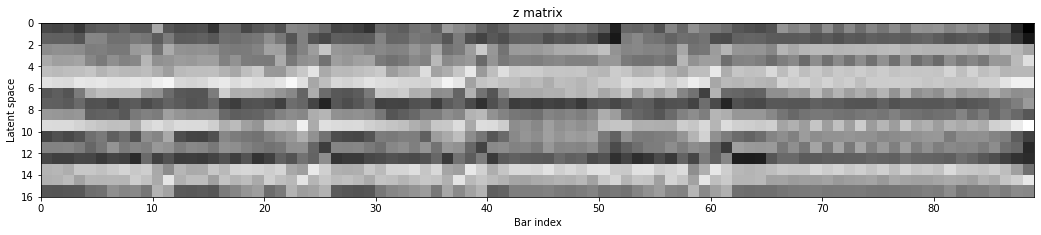

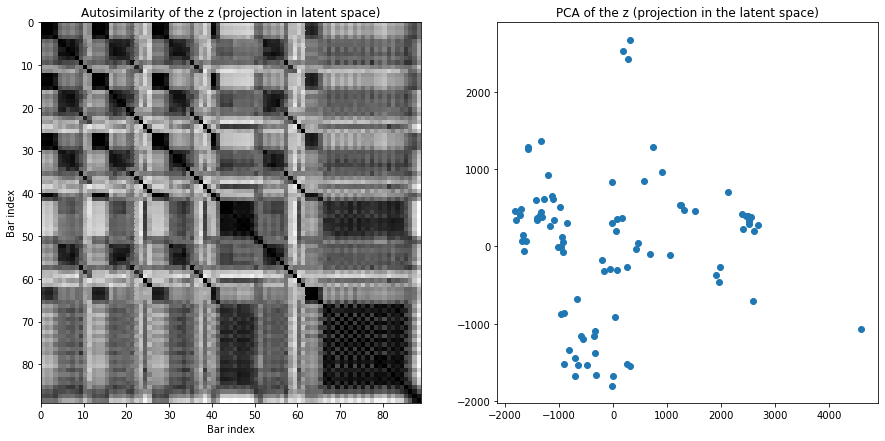

In [10]:
projection_mfcc = conv_mfcc_model.get_latent_projection(mfcc_data_loader)
plot_latent_space(projection_mfcc, labels = None)

## Mel-spec

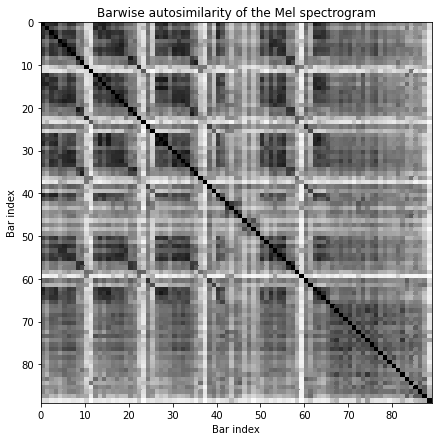

In [11]:
mel_spectrogram = features.get_spectrogram(the_signal, sampling_rate, "mel_grill", hop_length = hop_length)
mel_x_axis = mel_spectrogram.shape[0]

mel_tensor_barwise = nn_utils.tensorize_barwise(mel_spectrogram, bars, hop_length_seconds, subdivision_bars)
mel_autosimilarity = as_seg.get_autosimilarity(tl.unfold(mel_tensor_barwise,0), transpose = True, normalize = True)
plot_me_this_spectrogram(mel_autosimilarity, title = "Barwise autosimilarity of the Mel spectrogram", x_axis = "Bar index", y_axis = "Bar index")

In [12]:
mel_data_loader = nn_utils.generate_dataloader(mel_tensor_barwise)

conv_mel_model = conv_ae.ConvolutionalAutoencoder(input_size_x = subdivision_bars, input_size_y = mel_x_axis, dim_latent_space = 16)
print(conv_mel_model)
conv_mel_model = conv_mel_model.my_optim_method(1000, mel_data_loader, lr=1e-3,verbose = False)

ConvolutionalAutoencoder(
  (conv1): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(4, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc): Linear(in_features=7680, out_features=16, bias=True)
  (i_fc): Linear(in_features=16, out_features=7680, bias=True)
  (t_conv1): ConvTranspose2d(16, 4, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  (t_conv2): ConvTranspose2d(4, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
)


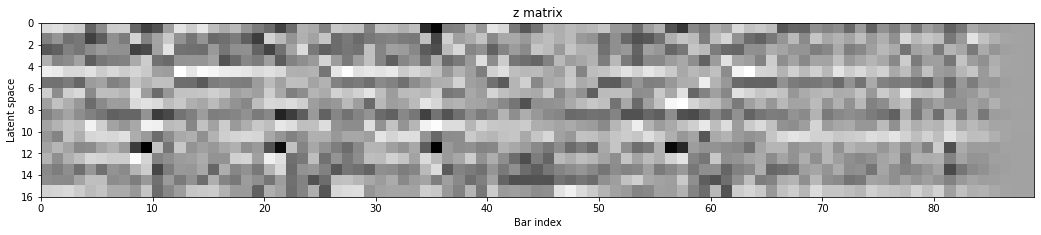

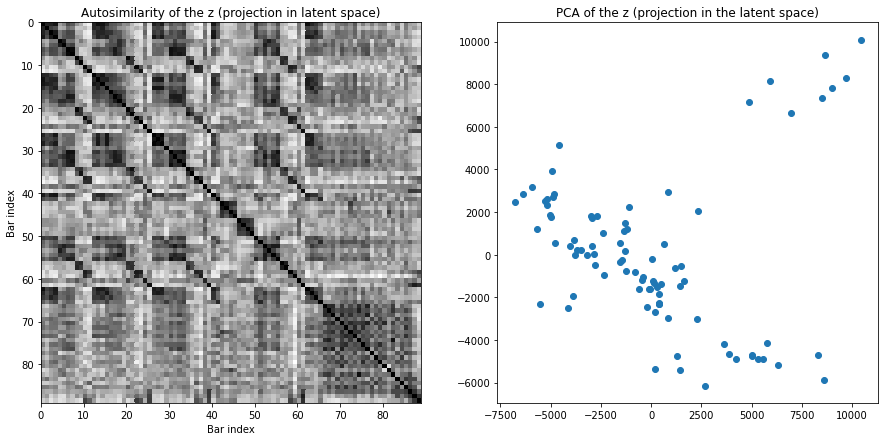

In [13]:
projection_mel = conv_mel_model.get_latent_projection(mel_data_loader)
plot_latent_space(projection_mel)

## Log-Mel-spec

In [14]:
log_mel_spectrogram = features.get_spectrogram(the_signal, sampling_rate, "log_mel_grill", hop_length = hop_length)

log_mel_tensor_barwise = nn_utils.tensorize_barwise(log_mel_spectrogram, bars, hop_length_seconds, subdivision_bars)
log_mel_autosimilarity = as_seg.get_autosimilarity(tl.unfold(log_mel_tensor_barwise,0), transpose = True, normalize = True)

plot_me_this_spectrogram(log_mel_spectrogram, title = "Barwise autosimilarity of the Log Mel spectrogram", x_axis = "Bar index", y_axis = "Bar index")

NameError: name 'cf' is not defined

In [ ]:
log_mel_data_loader = nn_utils.generate_dataloader(log_mel_tensor_barwise)

conv_log_mel_model = conv_ae.ConvolutionalAutoencoder(input_size_x = subdivision_bars, input_size_y = mel_x_axis, dim_latent_space = 16)
print(conv_log_mel_model)
conv_log_mel_model = conv_log_mel_model.my_optim_method(1000, log_mel_data_loader, lr=1e-3,verbose = False)

In [ ]:
projection_log_mel = conv_log_mel_model.get_latent_projection(log_mel_data_loader)
cf.plot_latent_space(projection_log_mel)